## Notebook : 03_model_transfer_learning.ipynb
- Objectif : Comparer plusieurs modèles UNet avec backbones pré-entraînés (Transfer Learning)
# 1 - Imports & préparation
## 1.1 - Librairies standards

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import mixed_precision
import mlflow

In [2]:
print("✅ TensorFlow version :", tf.__version__)

✅ TensorFlow version : 2.10.1


In [3]:
print("GPU dispo :", tf.config.list_physical_devices("GPU"))

GPU dispo : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.2 - Ajout des dossiers src/ et scripts/ au PYTHONPATH

In [4]:
project_root = Path().resolve().parent  # on part du dossier du notebook
src_path = project_root / "src"
scripts_path = project_root / "scripts"

for path in [src_path, scripts_path]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

In [5]:
print("project_root =", project_root)
print("src_path =", src_path)

project_root = C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation
src_path = C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\src


### Lancer, dans une console séparée (windows):
#### - nvidia-smi
- Cela affichera :

    - la charge GPU

    - la mémoire utilisée

    - le nom du process Python en cours

In [6]:
from gpu_setup import enable_gpu_boost
enable_gpu_boost()

✅ TensorFlow version : 2.10.1
🟢 GPU détecté : /physical_device:GPU:0
🔧 GPU utilisé : /device:GPU:0 | Mémoire : 4.5 GB


## 1.3 - Configuration des chemins et environnement
- Chemins relatifs depuis notebooks/, vers data/ à la racine du projet

In [7]:
data_dir = project_root / "data" / "processed" / "augmented"
outputs_dir = project_root / "outputs" / "figures"
logs_dir = project_root / "outputs" / "logs"
models_dir = project_root / "models"

outputs_dir.mkdir(parents = True, exist_ok = True)
logs_dir.mkdir(parents = True, exist_ok = True)

## 1.4 - Chargement du mouchard guardrail pour prévenir les erreurs liées à l'environnement

In [8]:
from utils.guardrail import check_paths_exist, check_imports

check_paths_exist([
    models_dir,
    data_dir / "train.npz",
    data_dir / "val.npz"
])

check_imports([
    "model_training.metrics",
    "utils.viz_utils"
])

✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\models
✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\data\processed\augmented\train.npz
✅ Chemin OK : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\data\processed\augmented\val.npz
✅ Import OK : model_training.metrics
✅ Import OK : utils.viz_utils


## 1.5 - Vérification de la validité des modèles sauvegardés

In [9]:
from model_training.metrics import iou_score, dice_coef
from utils.guardrail import check_models_validity

check_models_validity(models_dir, custom_objects={"iou_score": iou_score, "dice_coef": dice_coef})

⚠️ Aucun fichier modèle .h5 trouvé dans : C:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\models


# 2 - Chargement des données pré-traitées (.npz)
## 2.1 - Lecture des fichiers .npz

In [10]:
print("[INFO] Chargement des données .npz...")
train = np.load(data_dir / "train.npz")
val   = np.load(data_dir / "val.npz")

X_train, Y_train = train["X"], train["Y"]
X_val, Y_val     = val["X"], val["Y"]

print(f"\n✅ Données chargées : {X_train.shape} / {Y_train.shape}")

[INFO] Chargement des données .npz...

✅ Données chargées : (2380, 256, 256, 3) / (2380, 256, 256)


# 3 - Import du module d'entraînement multi-backbones

In [11]:
from model_training.train_unet_backbones import train_unet_with_backbone

# 4 - Configuration des tests
## 4.1 - Liste des backbones à tester

In [12]:
backbones = ["vgg16", "mobilenetv2", "efficientnetb0"]

## 4.2 - Paramètres communs à tous les modèles

In [13]:
params = {
    'img_size': (256, 256),
    'epochs': 40,
    'batch_size': 4,
    'use_early_stopping': True,
    'force_retrain': False
}

# 5 - Entraînement de tous les modèles + collecte des résultats
## 5.1 - Boucle d'entraînement

In [14]:
from utils.utils import clean_gpu_cache


In [15]:
results = []


🧪 Entraînement du modèle UNet + VGG16...
🧹 Cache GPU nettoyé
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_with_backbone appelé
[INFO] Modèle existant pour vgg16 : reconstruction + chargement des poids...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ build_unet_backbone appelé

📊 Résumé intermédiaire - VGG16 :
IoU max       : 0.6997
Dice max      : 0.8222
Accuracy max  : 0.8226
Epochs effectués : 16


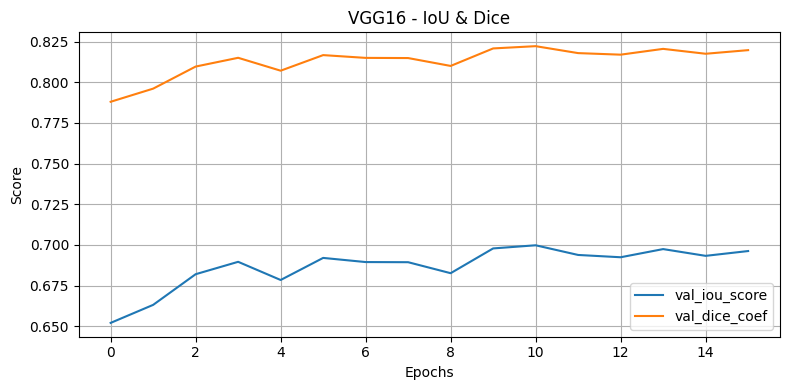


🧪 Entraînement du modèle UNet + MOBILENETV2...
🧹 Cache GPU nettoyé
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_with_backbone appelé
[INFO] Modèle existant pour mobilenetv2 : reconstruction + chargement des poids...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ build_unet_backbone appelé

📊 Résumé intermédiaire - MOBILENETV2 :
IoU max       : 0.6784
Dice max      : 0.8072
Accuracy max  : 0.8076
Epochs effectués : 9


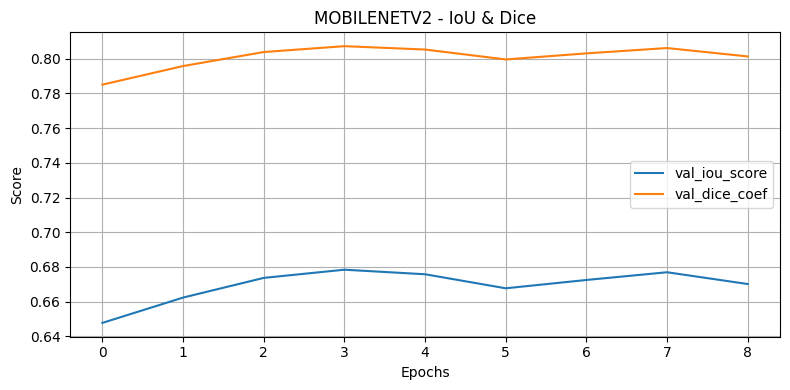


🧪 Entraînement du modèle UNet + EFFICIENTNETB0...
🧹 Cache GPU nettoyé
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_with_backbone appelé
[INFO] Initialisation du modèle UNet avec backbone : efficientnetb0
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ build_unet_backbone appelé
Epoch 1/40
595/595 [==============================] - 50s 71ms/step - loss: 1.0827 - accuracy: 0.5990 - iou_score: 0.4332 - dice_coef: 0.5990 - val_loss: 0.9327 - val_accuracy: 0.6363 - val_iou_score: 0.4686 - val_dice_coef: 0.6367
Epoch 2/40
595/595 [==============================] - 40s 67ms/step - loss: 0.9380 - accuracy: 0.6389 - iou_score: 0.4714 - dice_coef: 0.6389 - val_loss: 0.9168 - val_accuracy: 0.6436 - val_iou_score: 0.4771 - val_dice_coef: 0.6443
Epoch 3/40
595/595 [==============================] - 40s 67ms/step - loss: 0.9266 - accuracy: 0.6419 - iou_score: 0.4748 - dice_coef: 0.6419 - val_loss: 0.9355 - val_accuracy: 0.6432 - val_iou_score: 0.4776 - val_

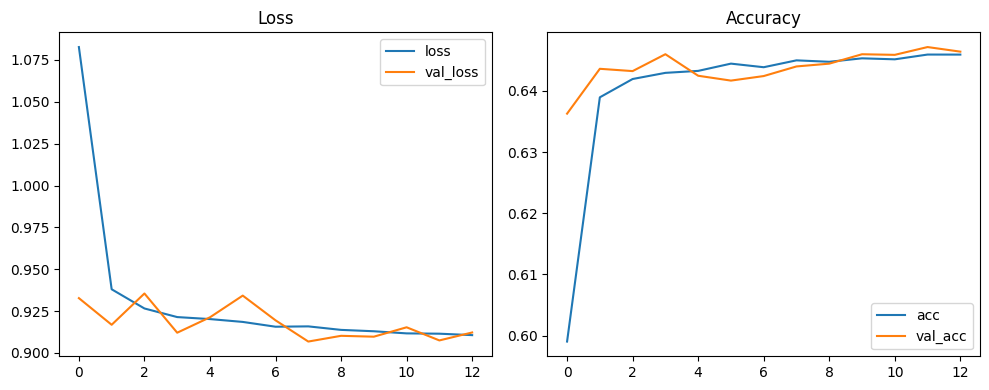

2025/04/22 15:05:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run unet_efficientnetb0_256x256_bs4_ep40 at: http://127.0.0.1:5000/#/experiments/0/runs/2d81b7404d974781a38936035f89371e.
2025/04/22 15:05:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/0.



📊 Résumé intermédiaire - EFFICIENTNETB0 :
IoU max       : 0.4814
Dice max      : 0.6479
Accuracy max  : 0.6471
Epochs effectués : 13


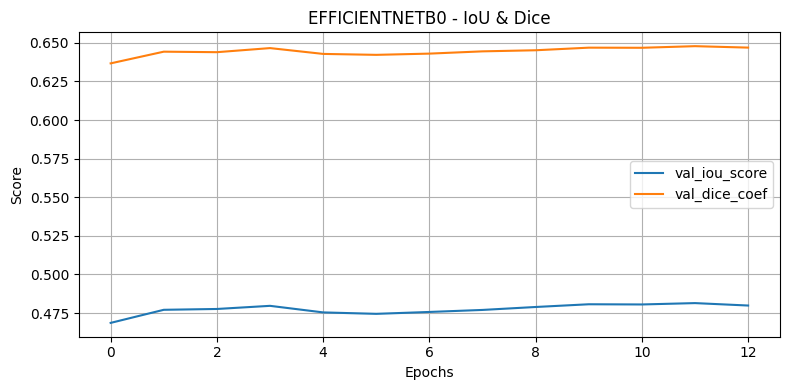

In [ ]:
for b in backbones:
    print(f"\n🧪 Entraînement du modèle UNet + {b.upper()}...")

    # Nettoyage GPU
    clean_gpu_cache()
    print("🧹 Cache GPU nettoyé")

    # ⚠️ Gestion du force_retrain spécifique à chaque backbone
    # force_retrain = (b == "efficientnetb0")  # True uniquement pour efficientnetb0

    model, history = train_unet_with_backbone(
        backbone_name=b,
        X_train=X_train,
        Y_train=Y_train,
        X_val=X_val,
        Y_val=Y_val,
        force_retrain=False,
        img_size=params['img_size'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        use_early_stopping=params['use_early_stopping']
    )

    val_iou = max(history["val_iou_score"])
    val_dice = max(history["val_dice_coef"])
    val_acc = max(history["val_accuracy"])
    train_time = len(history["loss"])

    results.append({
        "backbone": b,
        "val_iou": val_iou,
        "val_dice": val_dice,
        "val_accuracy": val_acc,
        "epochs_run": train_time
    })

    # Visualisation
    print(f"\n📊 Résumé intermédiaire - {b.upper()} :")
    print(f"IoU max       : {val_iou:.4f}")
    print(f"Dice max      : {val_dice:.4f}")
    print(f"Accuracy max  : {val_acc:.4f}")
    print(f"Epochs effectués : {train_time}")

    plt.figure(figsize=(8, 4))
    plt.plot(history["val_iou_score"], label="val_iou_score")
    plt.plot(history["val_dice_coef"], label="val_dice_coef")
    plt.title(f"{b.upper()} - IoU & Dice")
    plt.xlabel("Epochs")
    plt.ylabel("Score")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outputs_dir / f"curve_iou_dice_{b}.png")
    plt.show()

# 6 - Synthèse comparative des performances
## 6.1 - Visualisation tabulaire

In [17]:
results_df = pd.DataFrame(results)
display(results_df.sort_values(by = "val_iou", ascending = False))

,backbone,val_iou,val_dice,val_accuracy,epochs_run
0,vgg16,0.699729,0.822153,0.822582,16
1,mobilenetv2,0.678380,0.807226,0.807603,9
2,efficientnetb0,0.481442,0.647873,0.647145,13


## 6.2 - Export CSV + log intermédiaire

In [18]:
results_df.to_csv(logs_dir / "backbones_runs.csv", index = False)

## 6.3 - Visualisation graphique

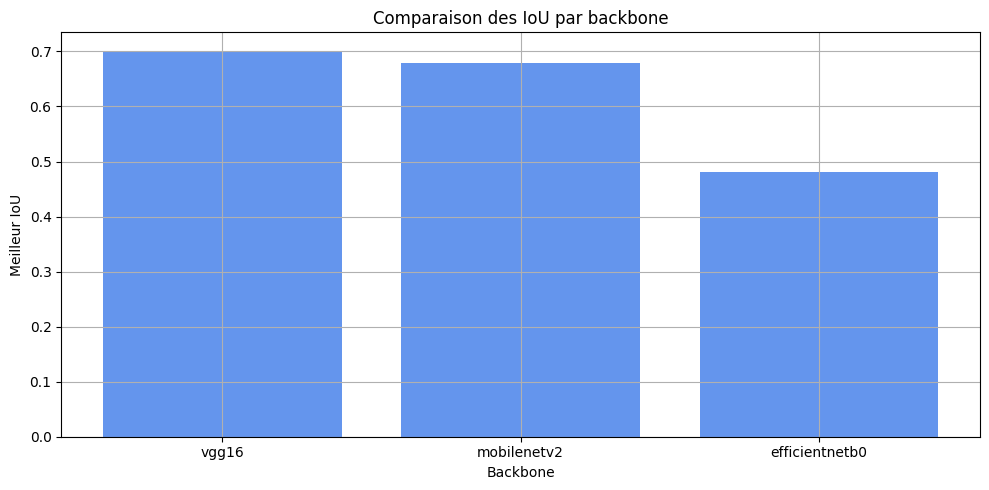

In [19]:
plt.figure(figsize=(10,5))
plt.bar(results_df["backbone"], results_df["val_iou"], color='cornflowerblue')
plt.title("Comparaison des IoU par backbone")
plt.ylabel("Meilleur IoU")
plt.xlabel("Backbone")
plt.grid(True)
plt.tight_layout()
plt.savefig(outputs_dir / "backbone_comparison_iou.png")
plt.show()

## 6.4 - Heatmap IoU vs Dice

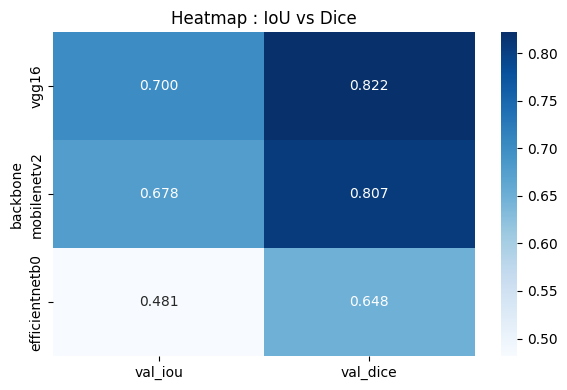

In [20]:
heat_data = results_df.set_index("backbone")[["val_iou", "val_dice"]]
plt.figure(figsize=(6, 4))
sns.heatmap(heat_data, annot=True, cmap="Blues", fmt=".3f")
plt.title("Heatmap : IoU vs Dice")
plt.tight_layout()
plt.savefig(outputs_dir / "heatmap_iou_dice.png")
plt.show()

# 7 - Sélection du meilleur modèle + préparation pour Optuna
## 7.1 - Sélection automatique du backbone le plus performant (IoU)

In [21]:
best_row = results_df.sort_values(by="val_iou", ascending=False).iloc[0]
best_backbone = best_row["backbone"]
print(f"\n🏆 Meilleur backbone sélectionné automatiquement : {best_backbone.upper()}")


🏆 Meilleur backbone sélectionné automatiquement : VGG16
